In [25]:
import pandas as pd
from datetime import datetime as dt, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors 

In [26]:
df = pd.read_csv('online_retail.csv')

In [27]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [28]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [29]:
## Finiding each customers RFM Values

# Recency

# Define the reference date as a Timestamp
day = pd.to_datetime('2012-01-01')

# Convert InvoiceDate column to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency
recency = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (day - x.max()).days})

# Rename the column for clarity
recency.rename(columns={"InvoiceDate": "Recency"}, inplace=True)

print(recency.head(3))







            Recency
CustomerID         
12346.0         347
12347.0          24
12348.0          97


In [30]:
# Frequency

freq=df.drop_duplicates(subset="InvoiceNo").groupby(["CustomerID"])[["InvoiceNo"]].count()
freq.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [31]:
#  Monetary Value

df["total"]=df["UnitPrice"]*df["Quantity"]
money = df.groupby(["CustomerID"])[["total"]].sum()
money.head()

,total
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [32]:
RFM = pd.concat([recency,freq,money],axis=1)
recency.columns=["Recency"]
freq.columns=["Frequency"]
money.columns=["Monetary"]

In [34]:
# Rename the 'InvoiceNo' column in freq to 'Frequency'
freq.columns = ["Frequency"]

# Concatenate the DataFrames
RFM = pd.concat([recency, freq, money], axis=1)

# Ensure correct column names for recency, frequency, and monetary
RFM.columns = ["Recency", "Frequency", "Monetary"]

# Check the final RFM DataFrame
print(RFM.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         347          2      0.00
12347.0          24          7   4310.00
12348.0          97          4   1797.24
12349.0          40          1   1757.55
12350.0         332          1    334.40


In [35]:
RFM

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,347,2,0.00
12347.0,24,7,4310.00
12348.0,97,4,1797.24
12349.0,40,1,1757.55
12350.0,332,1,334.40
...,...,...,...
18280.0,299,1,180.60
18281.0,202,1,80.82
18282.0,29,3,176.60


In [36]:
## Standarize the dataset to form a common scale to help the machine learning model

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
rfm_scaled=scaler.fit_transform(RFM)

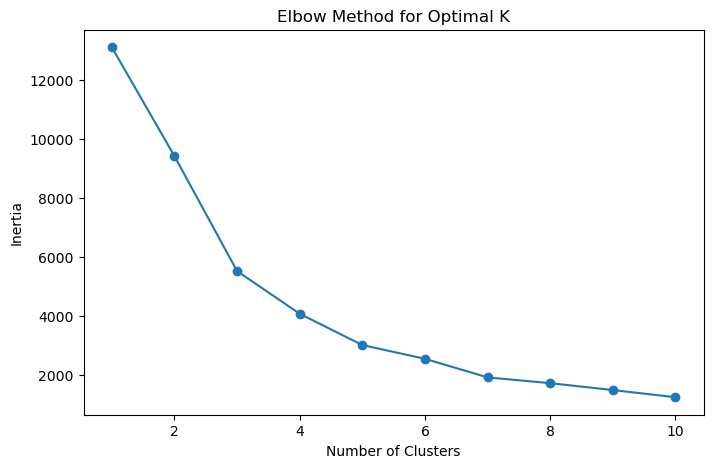

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming `scaled` is your scaled dataset
inertia = []
for i in np.arange(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker="o")  # Correct marker style
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


# since the elbow is between 2 and 4 I would asssumen number of cluster is 3

In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_scaled)
RFM["Clusters"]=(kmeans.labels_ +1)

RFM

,Recency,Frequency,Monetary,Clusters
CustomerID,,,,
12346.0,347,2,0.00,1
12347.0,24,7,4310.00,3
12348.0,97,4,1797.24,3
12349.0,40,1,1757.55,3
12350.0,332,1,334.40,1
...,...,...,...,...
18280.0,299,1,180.60,1
18281.0,202,1,80.82,1
18282.0,29,3,176.60,3


In [39]:
group = RFM.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean()
print(group)


             Recency  Frequency      Monetary
Clusters                                     
1         267.430631   1.854054    460.162695
2          27.521739  86.869565  81835.857391
3          61.468354   5.598642   1823.729701


In [40]:
def func(row):
    if row["Clusters"] == 1:
        return "Avg Cx"
    elif row["Clusters"] == 3:
        return "Whales Cx"
    else:
        return "Lapsed Cx"

In [41]:
RFM["Condition"] = RFM.apply(func,axis=1)
RFM

,Recency,Frequency,Monetary,Clusters,Condition
CustomerID,,,,,
12346.0,347,2,0.00,1,Avg Cx
12347.0,24,7,4310.00,3,Whales Cx
12348.0,97,4,1797.24,3,Whales Cx
12349.0,40,1,1757.55,3,Whales Cx
12350.0,332,1,334.40,1,Avg Cx
...,...,...,...,...,...
18280.0,299,1,180.60,1,Avg Cx
18281.0,202,1,80.82,1,Avg Cx
18282.0,29,3,176.60,3,Whales Cx


In [42]:
result = RFM["Condition"].value_counts()
result

Condition
Whales Cx    3239
Avg Cx       1110
Lapsed Cx      23
Name: count, dtype: int64

## More Advanced Techniques

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime as dt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import mode
from sklearn.metrics import silhouette_score


In [46]:
# Hyperparameter Tuning for K-Means
silhouette_scores = {}
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores[k] = silhouette_score(rfm_scaled, labels)

best_k = max(silhouette_scores, key=silhouette_scores.get)
kmeans = KMeans(n_clusters=best_k, random_state=42)
RFM['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)


In [47]:
# Hierarchical Clustering
linkage_matrix = linkage(rfm_scaled, method='ward')
RFM['Hierarchical_Cluster'] = fcluster(linkage_matrix, t=best_k, criterion='maxclust')


In [48]:
# Hyperparameter Tuning for DBSCAN
best_eps, best_min_samples, best_silhouette = 0, 0, -1
for eps in [0.5, 1.0, 1.5]:
    for min_samples in [5, 10, 15]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(rfm_scaled)
        if len(set(labels)) > 1 and -1 in labels:
            silhouette = silhouette_score(rfm_scaled, labels)
            if silhouette > best_silhouette:
                best_eps, best_min_samples, best_silhouette = eps, min_samples, silhouette

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
RFM['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)


In [49]:
# Hyperparameter Tuning for Gaussian Mixture Model (GMM)
best_gmm_components, best_gmm_covariance, best_gmm_silhouette = 0, '', -1
for components in [3, 4, 5, 6]:
    for covariance in ['full', 'tied', 'diag', 'spherical']:
        gmm = GaussianMixture(n_components=components, covariance_type=covariance, random_state=42)
        labels = gmm.fit_predict(rfm_scaled)
        silhouette = silhouette_score(rfm_scaled, labels)
        if silhouette > best_gmm_silhouette:
            best_gmm_components, best_gmm_covariance, best_gmm_silhouette = components, covariance, silhouette

gmm = GaussianMixture(n_components=best_gmm_components, covariance_type=best_gmm_covariance, random_state=42)
RFM['GMM_Cluster'] = gmm.fit_predict(rfm_scaled)

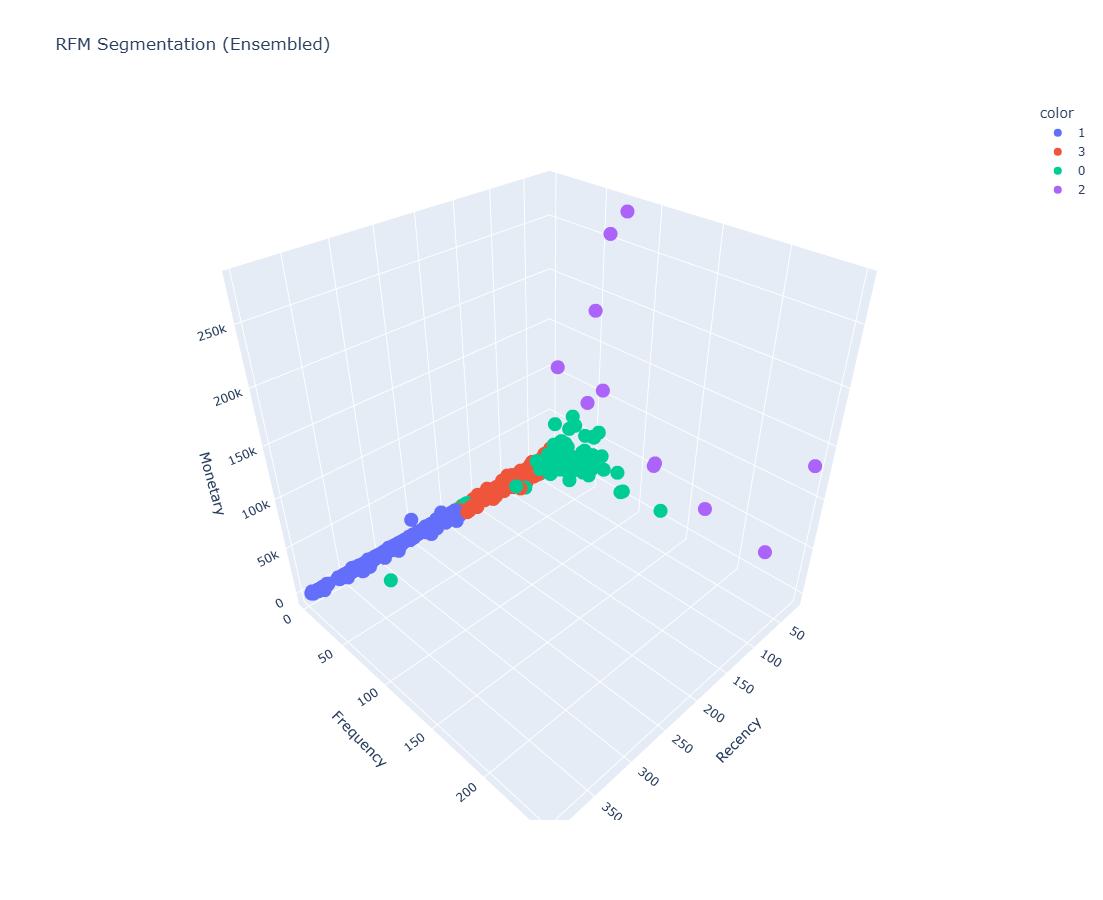

In [57]:
import plotly.express as px
from scipy.stats import mode

# Ensemble Clustering using Majority Voting
def majority_voting(row):
    clusters = [row['KMeans_Cluster'], row['Hierarchical_Cluster'], row['DBSCAN_Cluster'], row['GMM_Cluster']]
    return mode([c for c in clusters if c != -1], keepdims=True)[0][0]  # Ignore DBSCAN noise (-1)

RFM['Ensemble_Cluster'] = RFM.apply(majority_voting, axis=1)

# Visualize Clusters with increased image size
fig = px.scatter_3d(RFM, x='Recency', y='Frequency', z='Monetary',
                     color=RFM['Ensemble_Cluster'].astype(str),
                     title='RFM Segmentation (Ensembled)',
                     labels={'Ensemble_Cluster': 'Segment'})

# Increase the size of the 3D scatter plot
fig.update_layout(
    autosize=False,
    width=1200,  # Adjust the width as needed
    height=900   # Adjust the height as needed
)

fig.show()


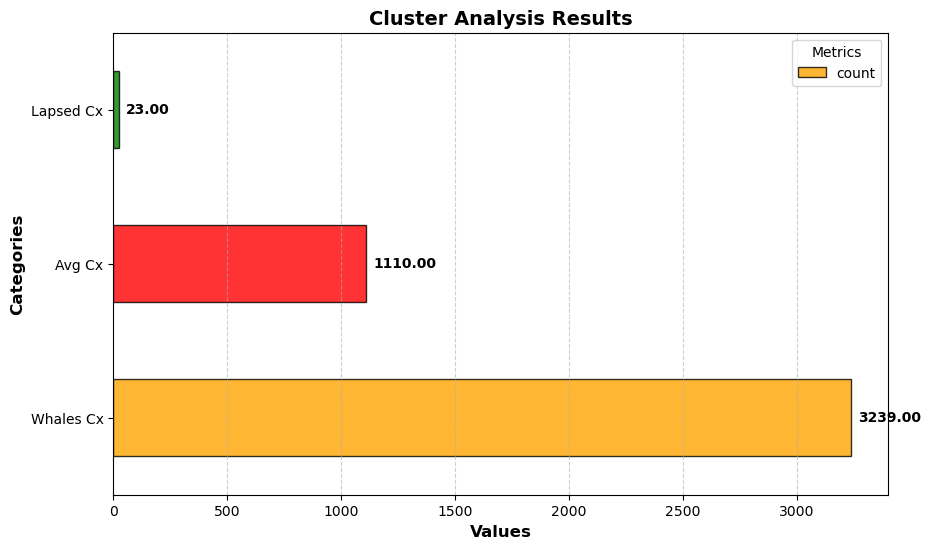

In [56]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot horizontal bar chart with custom colors
ax = result.plot(kind='barh', color=["orange", "red", "green"], edgecolor='black', alpha=0.8)

# Add labels to each bar
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.2f", padding=5, fontsize=10, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Set labels and title
plt.xlabel("Values", fontsize=12, fontweight='bold')
plt.ylabel("Categories", fontsize=12, fontweight='bold')
plt.title("Cluster Analysis Results", fontsize=14, fontweight='bold')

# Add a legend (if multiple columns exist in `result`)
plt.legend(title="Metrics", fontsize=10)

# Display the plot
plt.show()
